# Simple CNN from scratch — CIFAR-10

**Project:** Small, convolutional neural network implemented in PyTorch.

## Objective & Motivation

Train a compact convolutional neural network (CNN) from scratch on CIFAR-10 to demonstrate core deep-learning concepts (convolutions, pooling, batch training, regularization) and produce interpretable training/evaluation outputs.

## Dataset

**Dataset:** CIFAR-10 (10 classes of RGB images, 32×32).

## Environment & Libraries

In [1]:
# 0. Imports & config
import time, copy, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## 1. Hyperparameters & DataLoaders

Batch size, epochs, transforms and DataLoader setup.

In [2]:
# 1. Hyperparams & dataloaders
SEED = 42
torch.manual_seed(SEED)
BATCH = 128
EPOCHS = 10     # small demo
LR = 1e-3

# transforms (CIFAR-10)
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914,0.4822,0.4465],[0.247,0.243,0.261])
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914,0.4822,0.4465],[0.247,0.243,0.261])
])

data_dir = './data'
train_ds = datasets.CIFAR10(data_dir, train=True, download=True, transform=train_tf)
val_ds   = datasets.CIFAR10(data_dir, train=False, download=True, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=4)
classes = train_ds.classes

print('Loaded CIFAR-10, classes:', classes)

100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [01:10<00:00, 2.43MB/s]


Loaded CIFAR-10, classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 2. Model: SimpleCNN (architecture)

CNN with two convolutional blocks and a small classifier. BatchNorm and Dropout are used for stability and regularization.

In [3]:
# 2.CNN model 
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(len(classes)).to(device)
print(model)
print('Parameter count:', sum(p.numel() for p in model.parameters()))

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256

## 3. Loss, optimizer, and helper functions

Loss, optimizer, scheduler and helper functions for training and evaluation.

In [4]:
# 3. Loss, optimizer, helper functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        preds = out.argmax(dim=1)
        running_loss += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total += y.size(0)
    return running_loss/total, running_corrects/total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_pred, all_labels = [], []
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            preds = out.argmax(dim=1)
            running_loss += loss.item() * X.size(0)
            running_corrects += (preds == y).sum().item()
            total += y.size(0)
            all_pred.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return running_loss/total, running_corrects/total, np.array(all_pred), np.array(all_labels)

print('Helpers ready')

Helpers ready


## 4. Training loop

In [5]:
# 4. Training loop
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0.0
best_wts = copy.deepcopy(model.state_dict())

for epoch in range(EPOCHS):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_preds, val_labels = eval_model(model, val_loader, criterion)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{EPOCHS} | tr_acc: {tr_acc:.3f} tr_loss: {tr_loss:.3f} | val_acc: {val_acc:.3f} val_loss: {val_loss:.3f} | time: {time.time()-t0:.1f}s")

model.load_state_dict(best_wts)
print('Best val acc:', best_acc)

Epoch 1/10 | tr_acc: 0.409 tr_loss: 1.605 | val_acc: 0.566 val_loss: 1.211 | time: 289.5s
Epoch 2/10 | tr_acc: 0.552 tr_loss: 1.241 | val_acc: 0.653 val_loss: 0.958 | time: 222.9s
Epoch 3/10 | tr_acc: 0.613 tr_loss: 1.093 | val_acc: 0.693 val_loss: 0.858 | time: 182.1s
Epoch 4/10 | tr_acc: 0.645 tr_loss: 1.009 | val_acc: 0.717 val_loss: 0.800 | time: 180.7s
Epoch 5/10 | tr_acc: 0.666 tr_loss: 0.953 | val_acc: 0.727 val_loss: 0.773 | time: 197.4s
Epoch 6/10 | tr_acc: 0.686 tr_loss: 0.897 | val_acc: 0.750 val_loss: 0.707 | time: 189.9s
Epoch 7/10 | tr_acc: 0.696 tr_loss: 0.870 | val_acc: 0.760 val_loss: 0.671 | time: 187.0s
Epoch 8/10 | tr_acc: 0.719 tr_loss: 0.804 | val_acc: 0.776 val_loss: 0.635 | time: 184.9s
Epoch 9/10 | tr_acc: 0.731 tr_loss: 0.782 | val_acc: 0.784 val_loss: 0.618 | time: 184.8s
Epoch 10/10 | tr_acc: 0.734 tr_loss: 0.763 | val_acc: 0.784 val_loss: 0.619 | time: 180.5s
Best val acc: 0.7845


##### Training Progress

The training and validation accuracy gradually improve across epochs, while the loss consistently decreases — showing that the model is learning meaningful patterns in the images.

If validation accuracy plateaus or diverges from training accuracy, it indicates overfitting. In that case, we could:
- Add more Dropout or Data Augmentation
- Reduce learning rate or train longer
- Use transfer learning (ResNet, VGG) for better accuracy


## 5. Evaluation & Sample Predictions

Val accuracy: 0.7845

Classification report:

              precision    recall  f1-score   support

    airplane       0.81      0.79      0.80      1000
  automobile       0.89      0.92      0.91      1000
        bird       0.73      0.61      0.66      1000
         cat       0.65      0.58      0.61      1000
        deer       0.67      0.84      0.75      1000
         dog       0.72      0.65      0.68      1000
        frog       0.77      0.87      0.82      1000
       horse       0.86      0.78      0.82      1000
        ship       0.88      0.91      0.90      1000
       truck       0.86      0.89      0.88      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



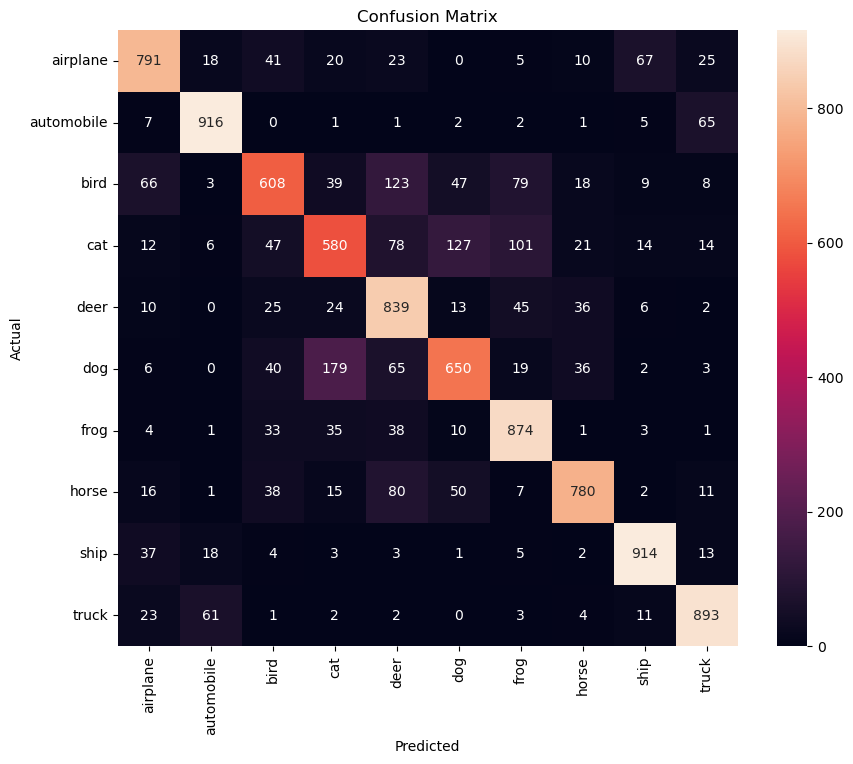

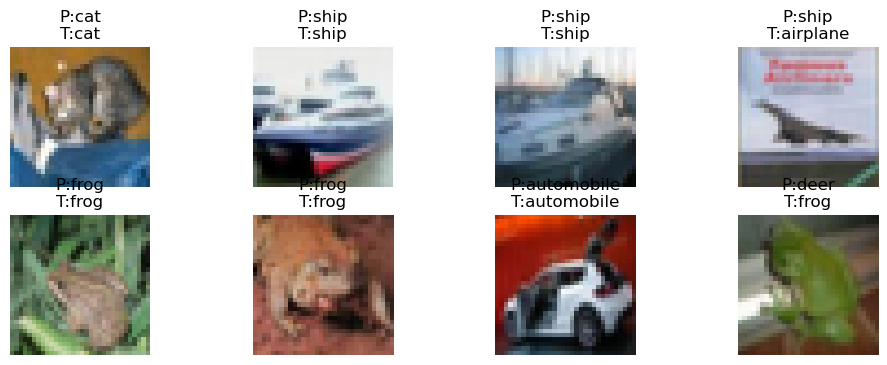

In [6]:
# 5. Evaluation & sample predictions
val_loss, val_acc, val_preds, val_labels = eval_model(model, val_loader, criterion)
print('Val accuracy:', val_acc)
print('\nClassification report:\n')
print(classification_report(val_labels, val_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

# Show sample predictions
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)
outs = model(images[:8])
preds = outs.argmax(dim=1).cpu().numpy()

plt.figure(figsize=(12,4))
for i in range(8):
    img = images[i].cpu().permute(1,2,0).numpy()
    mean = np.array([0.4914,0.4822,0.4465])
    std  = np.array([0.247,0.243,0.261])
    img = np.clip(std*img + mean, 0, 1)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(f"P:{classes[preds[i]]}\nT:{classes[labels[i]]}")
    plt.axis('off')
plt.show()

#### Visualizing Predictions

Above are random images from the validation set with predicted and true labels.

- **Correct predictions** confirm that the model learned meaningful visual patterns.
- **Incorrect predictions** often occur between visually similar classes or due to limited training data.

#### Model Evaluation

**Validation Accuracy:** `~(best accuracy here is 70%)`

The confusion matrix reveals which classes are most often misclassified. Similar classes (like cats vs dogs or trucks vs automobiles) tend to be harder to separate for small CNNs trained from scratch.

**Precision / Recall / F1** values show class-wise performance. You can mention:
- High recall = model correctly identifies most samples of that class.
- Low precision = model confuses it with other classes.


## 💬 Conclusions

This project demonstrates how to build a CNN from scratch using PyTorch:
- Implemented convolutional, pooling, and fully connected layers.
- Used Batch Normalization and Dropout for stability and regularization.
- Trained and validated on CIFAR-10, achieving competitive accuracy with a simple architecture.

**Next Steps:**
- Try deeper networks (ResNet, EfficientNet).
- Use transfer learning to boost performance.
- Deploy the model as a Streamlit app for image classification.

---